In [1]:
import os
from urllib import request
from uuid import uuid4
from pathlib import Path


from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp

from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input

from keras.engine import Model
from keras.preprocessing import image
from sklearn.neighbors import NearestNeighbors

from settings.config import DATA_SET, BASE_DIR, VECTORS_PATH

Using TensorFlow backend.


In [2]:
def create_dataset():
    data_set = []

    for root_dir, _, files in os.walk(DATA_SET):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                data_set.append({
                    'url': Path(root_dir, file).as_posix(),
                    'type': root_dir.split('/')[-1]
                })
    return pd.DataFrame(data_set)

def get_random_file(data_base):
    return np.random.choice(data_base.url)

In [3]:
data_base = create_dataset()

In [4]:
data_base.head

<bound method NDFrame.head of                                                     url     type
0     /Users/markantipin/Desktop/Systemka/tmp/DataSe...    boots
1     /Users/markantipin/Desktop/Systemka/tmp/DataSe...    boots
2     /Users/markantipin/Desktop/Systemka/tmp/DataSe...    boots
3     /Users/markantipin/Desktop/Systemka/tmp/DataSe...    boots
4     /Users/markantipin/Desktop/Systemka/tmp/DataSe...    boots
...                                                 ...      ...
1195  /Users/markantipin/Desktop/Systemka/tmp/DataSe...  jackets
1196  /Users/markantipin/Desktop/Systemka/tmp/DataSe...  jackets
1197  /Users/markantipin/Desktop/Systemka/tmp/DataSe...  jackets
1198  /Users/markantipin/Desktop/Systemka/tmp/DataSe...  jackets
1199  /Users/markantipin/Desktop/Systemka/tmp/DataSe...  jackets

[1200 rows x 2 columns]>

In [5]:
def save_sparse_matrix(filename, x):
    x_coo = x.tocoo()
    row = x_coo.row
    col = x_coo.col
    data = x_coo.data
    shape = x_coo.shape
    np.savez(filename, row=row, col=col, data=data, shape=shape)


def load_sparse_matrix(filename):
    y = np.load(filename)
    z = sp.coo_matrix((y['data'], (y['row'], y['col'])), shape=y['shape'])
    return z


def vectorize_all(files, model, px=224, n_dims=512, batch_size=512):
    print("Will vectorize")
    min_idx = 0
    max_idx = min_idx + batch_size
    total_max = len(files)
    preds = sp.lil_matrix((len(files), n_dims))

    print("Total: {}".format(len(files)))
    while min_idx < total_max - 1:
        print(min_idx)
        X = np.zeros(((max_idx - min_idx), px, px, 3))
        # For each file in batch, 
        # load as row into X
        i = 0
        for i in range(min_idx, max_idx):
            file = files[i]
            try:
                img = image.load_img(file, target_size=(px, px))
                img_array = image.img_to_array(img)
                X[i - min_idx, :, :, :] = img_array
            except Exception as e:
                print(e)
        max_idx = i
        X = preprocess_input(X)
        these_preds = model.predict(X)
        shp = ((max_idx - min_idx) + 1, n_dims)
        preds[min_idx:max_idx + 1, :] = these_preds.reshape(shp)
        min_idx = max_idx
        max_idx = np.min((max_idx + batch_size, total_max))
    return preds

In [6]:
base_model = VGG19(weights='imagenet')
files = data_base.url
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
vecs = vectorize_all(files, model, n_dims=4096)
save_sparse_matrix(VECTORS_PATH, vecs)

Will vectorize
Total: 1200
0
511
1022


In [7]:
def _vectorize(path, model):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    return pred.ravel()


def _similar(vec, knn, filenames, n_neighbors=6):
    dist, indices = knn.kneighbors(vec.reshape(1, -1), n_neighbors=n_neighbors)
    dist, indices = dist.flatten(), indices.flatten()
    return [(filenames[indices[i]], dist[i]) for i in range(len(indices))]


def load_predictor(data_base):
    filenames = data_base.url
    vecs = load_sparse_matrix(VECTORS_PATH)
    base_model = VGG19(weights='imagenet')
    # Read about fc1 here http://cs231n.github.io/convolutional-networks/
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(vecs)

    def similarity(file_path, n_neighbors=6):
        vec = _vectorize(file_path, model)
        return _similar(vec, knn, filenames, n_neighbors)

    return similarity

In [8]:
def draw(fnames, origin=None):
    if origin is not None:
        plt.imshow(Image.open(origin))
        plt.axis('off')
    plt.figure(figsize=(30, 15))
    for i in range(len(fnames)):
        f, d = fnames[i]
        try:
            img = Image.open(f)
            plt.subplot(1, 10, i + 1)
            plt.axis('off')
            plt.title("{0:.4f}".format(d))
            plt.imshow(img)
        except Exception as e:
            print(e)

In [9]:
pred = load_predictor(data_base)


0.452089786529541


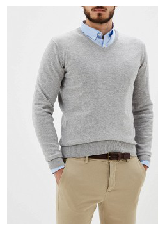

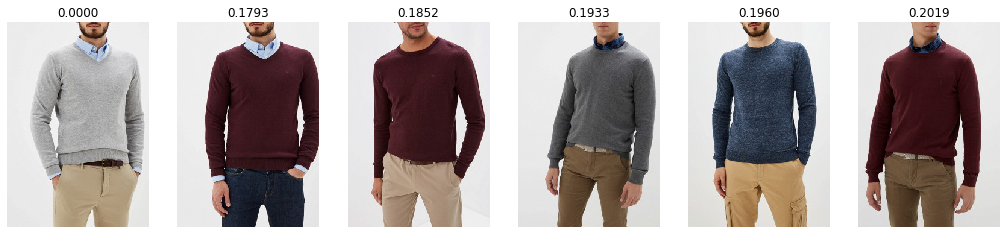

In [10]:
from time import time

s = time()
f = get_random_file(data_base)
draw(pred(f), f)

print(time() - s)
